# Segmentation sémantique avec Unet
![](https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/muenster00.png)

L'objectif de ce projet est de concevoir un modèle de segmentation d’images semantique. La segmentation sémantique est un algorithme de Deep Learning qui associe une catégorie à chaque pixel d'une image. Elle permet de reconnaître un ensemble de pixels qui forment des catégories distinctes.

Les images sont issues du jeux de données de [cityscape](https://www.cityscapes-dataset.com). Le nombre de categorie est réduit de 37 à 8.
  - void
  - flat
  - construction
  - object
  - nature
  - sky
  - human
  - vehicle


Dans ce notebook nous allons explorer un modèle **Unet** qui sera entrainé  avec une perte de type **Catégorical Cross Entropy** et avec une perte de type **Dice**.

## Calcul de la perte

### Catégorical Cross Entropy
Il s'agit d'une fonction de perte utilisée généralement pour des problème de catégorisation et qui mesure la sililarité entre deux distributions de probabilité, généralement les étiquettes rréelles et les étiquetes prédites.


## Modèle PSPNet
PSPNet
Le modèle U-net a été proposé pour la première fois par : Hengshuang Zhao, Jianping Shi, Xiaojuan Qi, Xiaogang Wang et Jiaya Jia dans leur article intitulé "Pyramid Scene Parsing Network"

![](https://www.researchgate.net/profile/Jian-Yang-77/publication/328852190/figure/fig4/AS:748544281554944@1555478272635/The-PSPNet-architecture-6.jpg)

Ce modèle est divisé en trois parties ; la première partie effectue l'extraction des caractéristiques à partir d’un CNN pré-entrainé, puis la deuxième partie (Pyramid Pooling Module) est constituée de 2 pyramides de 4 niveaux qui vont effectuer des convolutions, enfin la dernière partie est une couche de convolution qui va permettre de faire les prédictions.







# Chargement des bibliothèques

In [ ]:
import tensorflow as tf
from keras import optimizers
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import gc
import random
from keras.utils.vis_utils import plot_model

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Mount Google drive
from google.colab import drive
import os
import sys

drive.mount("/content/drive", force_remount=True)
app_folder = '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/'


Mounted at /content/drive


## Chargement des modules complémentaires

In [ ]:
# Copy modules
!cp -rf '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Models' .
!cp -rf '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Losses' .
!cp -rf '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Metrics' .
!cp -rf '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Dataset' .


In [ ]:
%reload_ext autoreload
from Models import build_model
from Losses import LOSS_FACTORY
from Metrics import METRIC_FACTORY
from Dataset import get_data
from Dataset import categories
from Dataset import load_data
from Dataset import set_color_to_mask
from Dataset import data_generator
from Dataset.data_generator import data_generator
from Metrics.iou_coef import IoU


# Definition des variables

In [ ]:
EPOCHS = 100
patience = 30
model_name = 'pspnet'
optimizer_name = 'adam'
n_classes = 8
input_height = 128
input_width = 256
BATCH_SIZE = 32


# Chargement des données

In [ ]:
# get Val data set frol google drive
get_data('gdrive',app_folder + 'data/', 'train')
gc.collect()

11

In [ ]:
# Load data into numpy array
imgs, masks = load_data('train', input_height,input_width, 3000)

In [ ]:
print(f"{len(imgs)} images and {len(masks)} images mask")
print(f"Images properties: {np.array(imgs).shape}")
print(f"Masks properties: {np.array(masks).shape}")

2975 images and 2975 images mask
Images properties: (2975, 128, 256, 3)
Masks properties: (2975, 128, 256, 8)


# Preparation du modèle PSPNet

In [ ]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(np.squeeze(imgs), np.squeeze(masks), test_size=0.25, random_state=63)
gc.collect()

50

## Construction du modèle

In [ ]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    patience=patience,
    verbose=1
  ),  
  tf.keras.callbacks.ReduceLROnPlateau('loss',
    factor=0.01,
    patience=int(patience / 2),
    verbose=1
  )
]
loss_func  = 'categorical_crossentropy'
model = build_model('pspnet',n_classes,input_height=input_height,input_width=input_width)
model.compile(loss=loss_func,optimizer='adam', metrics=['accuracy',METRIC_FACTORY['iou_coef'], METRIC_FACTORY['dice_coef']])
gc.collect()

707

In [ ]:
#model.summary()
#plot_model(model, to_file='model_pspnet.png', show_shapes=True, show_layer_names=True)


# Entrainement du modèle

In [ ]:
%%time
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_test.shape[0] // BATCH_SIZE

history = model.fit(
    X_train,
    y_train,
    steps_per_epoch=steps_per_epoch,     
    validation_data=(X_test,y_test), 
    epochs=EPOCHS,
    verbose=2,
    callbacks=[callbacks]
)


Epoch 1/100
69/69 - 122s - loss: 1.0289 - accuracy: 0.6340 - iou_coef: 0.3619 - dice_coef: 0.5155 - val_loss: 1.4041 - val_accuracy: 0.5667 - val_iou_coef: 0.3001 - val_dice_coef: 0.4590
Epoch 2/100
69/69 - 78s - loss: 0.5911 - accuracy: 0.8159 - iou_coef: 0.5687 - dice_coef: 0.7214 - val_loss: 1.8215 - val_accuracy: 0.5918 - val_iou_coef: 0.3823 - val_dice_coef: 0.5454
Epoch 3/100
69/69 - 80s - loss: 0.4957 - accuracy: 0.8430 - iou_coef: 0.6243 - dice_coef: 0.7648 - val_loss: 2.0582 - val_accuracy: 0.6088 - val_iou_coef: 0.4005 - val_dice_coef: 0.5627
Epoch 4/100
69/69 - 81s - loss: 0.4541 - accuracy: 0.8558 - iou_coef: 0.6489 - dice_coef: 0.7834 - val_loss: 1.6260 - val_accuracy: 0.6354 - val_iou_coef: 0.4453 - val_dice_coef: 0.6073
Epoch 5/100
69/69 - 82s - loss: 0.4260 - accuracy: 0.8648 - iou_coef: 0.6669 - dice_coef: 0.7963 - val_loss: 1.4931 - val_accuracy: 0.6498 - val_iou_coef: 0.4256 - val_dice_coef: 0.5884
Epoch 6/100
69/69 - 82s - loss: 0.3952 - accuracy: 0.8739 - iou_coef:

## Evaluation du modèle

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss : {score[0]}")
print(f"Acuracy : {score[1]}")
gc.collect()

24/24 [==============================] - 7s 305ms/step - loss: 0.6244 - accuracy: 0.9018 - iou_coef: 0.8147 - dice_coef: 0.8948
Loss : 0.6244473457336426
Acuracy : 0.9018256068229675


2476

## Exemples de prédictions

In [ ]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)

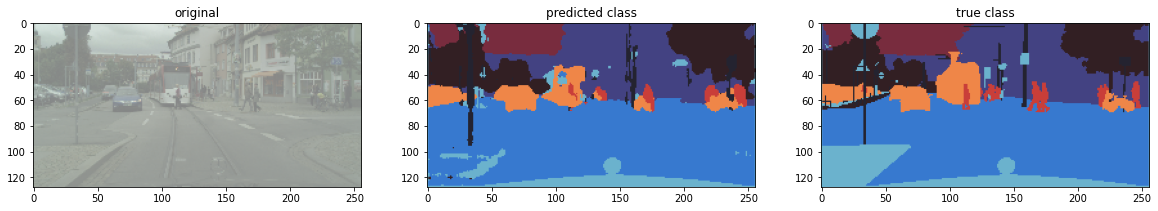

void          : 0.350
flat          : 0.467
construction  : 0.418
object        : 0.196
nature        : 0.436
sky           : 0.471
human         : 0.284
vehicle       : 0.381

Mean IoU: 0.375


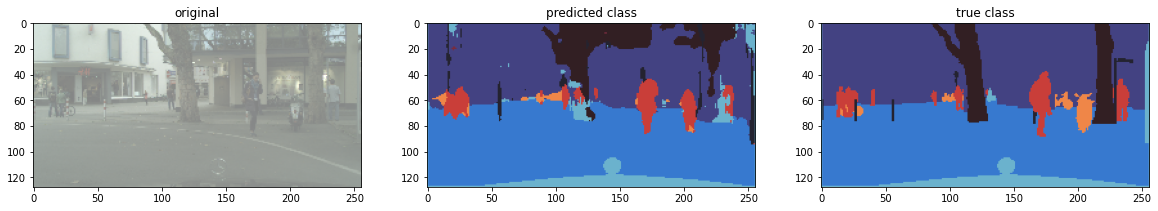

void          : 0.405
flat          : 0.489
construction  : 0.425
object        : 0.049
nature        : 0.258
sky           : 0.000
human         : 0.317
vehicle       : 0.096

Mean IoU: 0.255


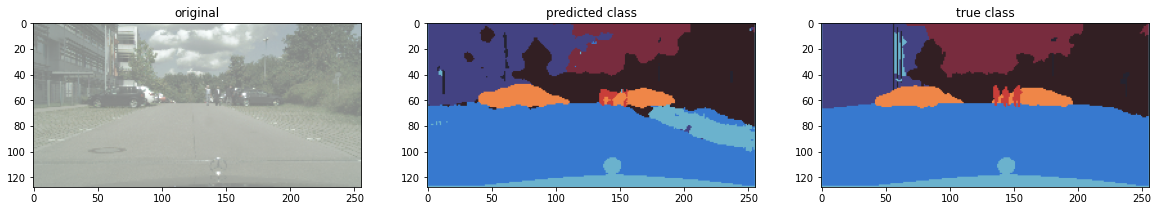

void          : 0.365
flat          : 0.467
construction  : 0.402
object        : 0.120
nature        : 0.466
sky           : 0.396
human         : 0.304
vehicle       : 0.442

Mean IoU: 0.370


In [ ]:
import random

random_images = random.sample(range(len(X_test)), 3)

for i in random_images:
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(20,40))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(set_color_to_mask(seg))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(set_color_to_mask(segtest))
    ax.set_title("true class")
    plt.show()

    IoU(y_testi[i],y_predi[i],categories)

# Conclusion
Le modèle PSPNet donne de très bons résultats, mais le temps d’entrainement est très long.  